# Sea ice and mesoscale cyclones in ERA5

In [1]:
import cartopy.crs as ccrs
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr
from tqdm import tqdm_notebook as tqdm

from arke.cart import lcc_map, lcc_map_grid

from common_defs import winters, nyr, winter_dates, iletters
from plot_utils import LCC_KW, trans, clev101, abs_plt_kw
import mypaths
from stars_api import read_tracks_file

from octant.core import TrackRun, OctantTrack, HOUR
from octant.misc import calc_all_dens, SUBSETS, DENSITY_TYPES
import octant
octant.__version__

In [3]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='dask')
warnings.filterwarnings('ignore', category=UserWarning, module='iris')

In [4]:
plt.style.use('paperfig.mplstyle')

In [5]:
lsm = xr.open_dataarray(mypaths.era5_dir / 'lsm.nc').squeeze()
lsm.attrs['units'] = 1
lon2d, lat2d = np.meshgrid(lsm.longitude, lsm.latitude)

### Get area weights to calculate the sea ice area

#### Calculate area weights using iris

In [6]:
import iris
from cf_units import Unit

In [7]:
lsm_cube = lsm.to_iris()

In [8]:
lsm_cube.coord('longitude').guess_bounds()
lsm_cube.coord('latitude').guess_bounds()

In [9]:
weights = lsm_cube.copy(data=iris.analysis.cartography.area_weights(lsm_cube, normalize=False))
weights.units = Unit('m^2')
weights.rename('area_weights')

Convert weights to $km^2$

In [10]:
weights.convert_units('km^2')

Convert to xarray dataarray

In [11]:
area_w = xr.DataArray.from_iris(weights)
area_w = area_w[(area_w.latitude >= 65) & (area_w.latitude <= 85), (area_w.longitude >= -20) & (area_w.longitude <= 50)]

## Load sea ice data

In [12]:
sea_ice_ds = xr.open_mfdataset(sorted(mypaths.era5_dir.glob('*.ci.nc')))

Extract sea ice cover array within the area used for tracking ($65-85N, 20W-50E$)

In [13]:
sea_ice_conc = sea_ice_ds.ci[:, (sea_ice_ds.latitude >= 65) & (sea_ice_ds.latitude <= 85), (sea_ice_ds.longitude >= -20) & (sea_ice_ds.longitude <= 50)]

### Sea ice area

By multiplying sea-ice cover variable from ERA5 by the area weights we obtain the **sea ice area**.

Note: this is not a sea ice extent (http://nsidc.org/arcticseaicenews/faq/#area_extent).

In [14]:
sic_thresh = 0.15  # 15% threshold

In [15]:
sea_ice_area = (sea_ice_conc * area_w).where(sea_ice_conc > sic_thresh, 0.)
# sea_ice_extent = (sea_ice_conc * 0.).where(sea_ice_conc < sic_thresh, 1.) * area_w

Get month numbers for each time step

In [16]:
month_series = sea_ice_area.time.dt.month

Create a boolen Dataaray that is true only during winter

In [17]:
extended_winter_mask = (month_series <= 4) | (month_series >= 10)

Mask the values not in winter and resample annualy starting in october

In [18]:
sea_ice_area_winter_mean = sea_ice_area.where(extended_winter_mask).resample(time='as-oct').mean('time')

In [19]:
sea_ice_conc_winter_mean = sea_ice_conc.where(extended_winter_mask).resample(time='as-oct').mean('time')

Add winter labels as an auxiliary coordinate

In [20]:
sea_ice_area_winter_mean['winter'] = ('time', winters)

In [21]:
total_sea_ice_area_over_winters = sea_ice_area_winter_mean.sum(dim=('longitude', 'latitude')) * 1e-6

### Calculate linear regression coeffiecients

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lr_model = LinearRegression(fit_intercept=True)

In [24]:
x = np.array(range(total_sea_ice_area_over_winters.shape[0]))

In [25]:
lr_model.fit(x[:, np.newaxis], total_sea_ice_area_over_winters.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
sia_trend = lr_model.predict(x[:, np.newaxis])

In [27]:
print(f'Sea ice area decrease per year [10^6 km^2]: {lr_model.coef_[0]:4.3f}')

Sea ice area decrease per year [10^6 km^2]: -0.025


In [28]:
xlabels = [i.replace('_', '-') for i in total_sea_ice_area_over_winters.winter.values]

In [29]:
min_idx = total_sea_ice_area_over_winters.argmin(dim='time').values
winter_min = str(total_sea_ice_area_over_winters.winter[min_idx].values)
max_idx = total_sea_ice_area_over_winters.argmax(dim='time').values
winter_max = str(total_sea_ice_area_over_winters.winter[max_idx].values)

Select winters with extreme sea ice concentration

In [30]:
sia_minimum = sea_ice_area_winter_mean[sea_ice_area_winter_mean.winter==winter_min].squeeze()
sia_maximum = sea_ice_area_winter_mean[sea_ice_area_winter_mean.winter==winter_max].squeeze()

In [31]:
ci_minimum = sea_ice_conc_winter_mean[sea_ice_area_winter_mean.winter==winter_min].squeeze()
ci_maximum = sea_ice_conc_winter_mean[sea_ice_area_winter_mean.winter==winter_max].squeeze()

#### Create the plot

In [32]:
lcc_kw_t = LCC_KW.copy()
lcc_kw_t['ticks'] = [6, 3]

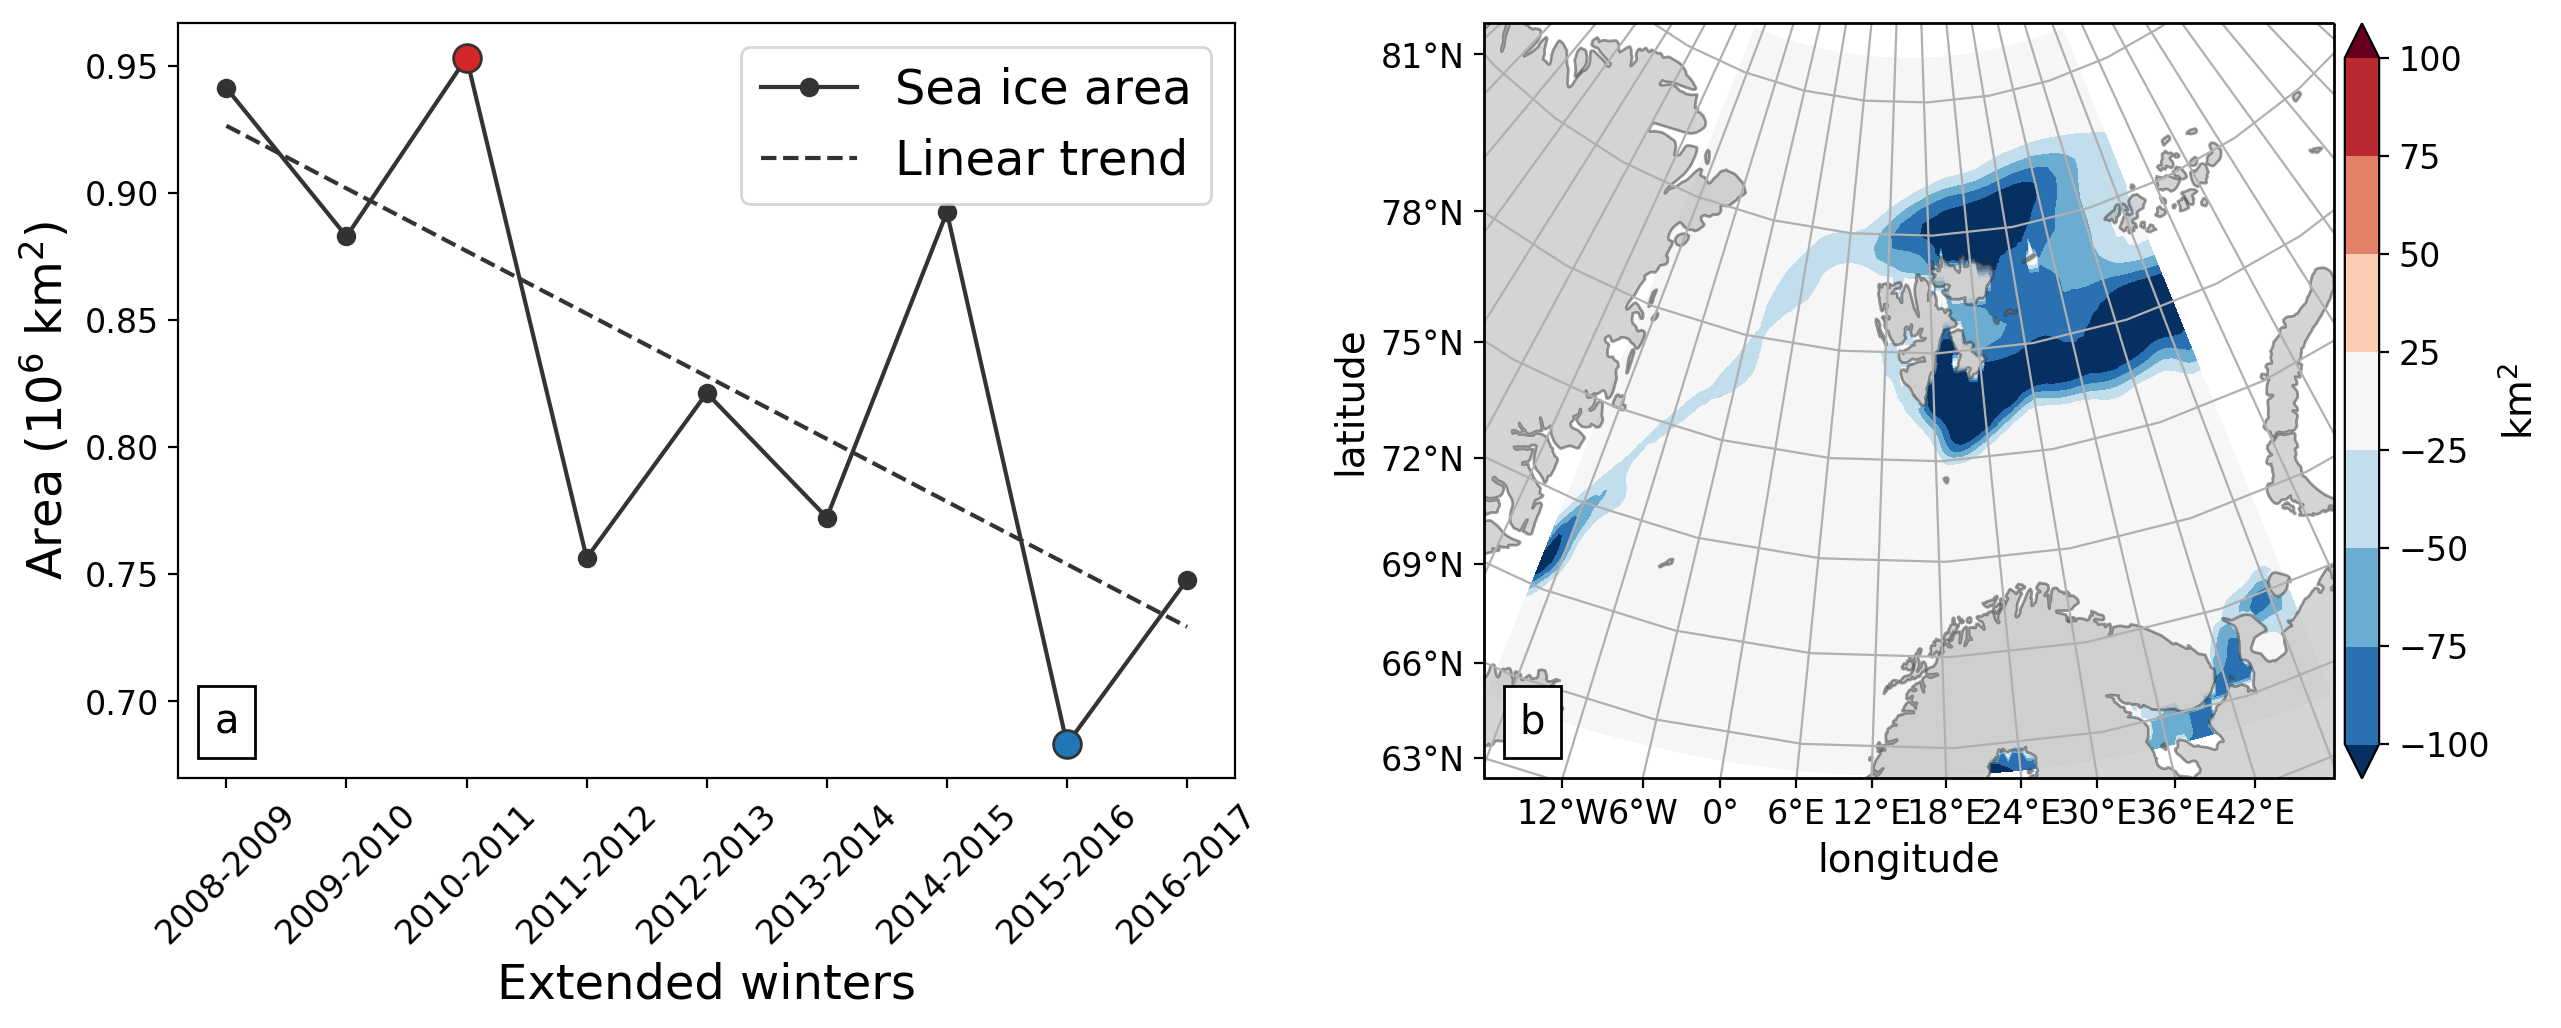

In [33]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
ax.plot(xlabels, total_sea_ice_area_over_winters, marker='o', color='#333333', label='Sea ice area')
ax.plot(xlabels, sia_trend, color='#333333', linestyle='--', label='Linear trend')
ax.plot(xlabels[max_idx], total_sea_ice_area_over_winters[max_idx], marker='o', mec='#333333', mfc='C3', ms=10)
ax.plot(xlabels[min_idx], total_sea_ice_area_over_winters[min_idx], marker='o', mec='#333333', mfc='C0', ms=10)
ax.legend(loc=1, fontsize='x-large')

ax.set_xlabel('Extended winters', fontsize='x-large')
ax.set_ylabel('Area ($10^6$ $km^2$)', fontsize='x-large')
ax.tick_params(axis='x', rotation=45)
ax.add_artist(AnchoredText('a', loc=3, prop=dict(size='large')))

ax = lcc_map(fig, 122, **lcc_kw_t)
h = (sia_minimum-sia_maximum).plot.contourf(ax=ax, extend='both',
                                            levels=clev101*100,
                                            add_colorbar=False,
                                            **trans)
cb = fig.colorbar(h, ax=ax, pad=0.01)
cb.ax.set_ylabel('$km^2$')
ax.add_artist(AnchoredText('b', loc=3, prop=dict(size='large')));

# fig.savefig(mypaths.plotdir / f'total_sea_ice_area_over_winters_era5')

In [34]:
total_sea_ice_area_over_winters[min_idx].values, total_sea_ice_area_over_winters[max_idx].values

(array(0.68322642), array(0.95311772))

## Load tracks

In [35]:
dataset = 'era5'

In [37]:
TR = TrackRun()
TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / 'era5_run000_2008_2017.parquet', engine='pyarrow'))

In [38]:
TR_seaice_min = TrackRun()
TR_seaice_min.data = TR.data[(TR.data['time'] >= winter_dates[winter_min][0]) & (TR.data['time'] <= winter_dates[winter_min][1])]

In [39]:
TR_seaice_max = TrackRun()
TR_seaice_max.data = TR.data[(TR.data['time'] >= winter_dates[winter_max][0]) & (TR.data['time'] <= winter_dates[winter_max][1])]

In [40]:
# TR_seaice_min = TrackRun(mypaths.trackresdir / dataset / f'run{run_id+run_id_start:03d}' / winter_min)
# TR_seaice_max = TrackRun(mypaths.trackresdir / dataset / f'run{run_id+run_id_start:03d}' / winter_max)
# TR.categorise(lsm=lsm,
#               filt_by_time=True, filt_by_dist=True, filt_by_vort=True,
#               filt_by_domain_bounds=True, filt_by_land=True,
#               time_thresh0=6, time_thresh1=9,
#               dist_thresh=300.0, type_thresh=0.2,
#               vort_thresh0=0.0003, vort_thresh1=0.00045, coast_rad=70.)

## Calculate density

In [41]:
lon_dens = np.arange(-20, 51, 1.)
lat_dens = np.arange(65, 86, 1.)
lon_dens, lat_dens = np.meshgrid(lon_dens, lat_dens)

In [42]:
minmax_dens = xr.Dataset(dict(dens_max=calc_all_dens(TR_seaice_max, lon_dens, lat_dens),
                              dens_min=calc_all_dens(TR_seaice_min, lon_dens, lat_dens)))
minmax_dens['dens_diff'] = minmax_dens.dens_min - minmax_dens.dens_max

In [43]:
# fig = plt.figure()
# ax = lcc_map(fig, **LCC_KW)
# minmax_dens.dens_diff.sel(subset='basic', dens_type='point').plot.contourf(ax=ax, cmap='coolwarm', extend='both', robust=True, **mapkey)

In [45]:
AXGR_KW = dict(axes_pad=0.45,
               cbar_location='right',
               cbar_mode='each',
               cbar_pad=0.05,
               cbar_size='3%')

diff_plt_kw = dict(cmap='coolwarm', extend='both', **trans)
cntr_kw = dict(colors='#222222', linewidths=0.25, **trans)
cntr_lab_kw = dict(fmt='%3.0f', colors='k')
ci_kw = dict(levels=[0.15], linewidths=2, **trans)
at_kw = dict(loc=2, prop=dict(size='small'))

In [ ]:
subsets = SUBSETS[1:]

In [ ]:
ncol = len(subsets)
nrow = 4

for subset in subsets:
    fig = plt.figure(figsize=(ncol*7, nrow*5))
    axgr = lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

    ax_labels = iter(string.ascii_lowercase)
    cbar_ax_iter = iter(axgr.cbar_axes)
    for axrow, dens_type in tqdm(zip(axgr.axes_row, DENSITY_TYPES), leave=False):

        ax = axrow[0]
        txt = f'({next(iletters)}) Sea ice maximum\n{winter_max.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_max.sel(subset=subset, dens_type=dens_type), **abs_plt_kw)
        levels = h.get_array()
        hh = ax.contour(lon_dens, lat_dens, minmax_dens.dens_max.sel(subset=subset, dens_type=dens_type), levels=levels, **cntr_kw)
        hhh = ax.clabel(hh, **cntr_lab_kw)
        plt.setp(hhh, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground='w')])
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_maximum.plot.contour(ax=ax, add_labels=False, colors='C3', **ci_kw)

        ax = axrow[1]
        txt = f'({next(iletters)}) Sea ice minimum\n{winter_min.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_min.sel(subset=subset, dens_type=dens_type), levels=levels, **abs_plt_kw)
        hh = ax.contour(lon_dens, lat_dens, minmax_dens.dens_min.sel(subset=subset, dens_type=dens_type), levels=levels, **cntr_kw)
        hhh = ax.clabel(hh, **cntr_lab_kw)
        plt.setp(hhh, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground='w')])
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_minimum.plot.contour(ax=ax, add_labels=False, colors='C9', **ci_kw)

        ax = axrow[2]
        txt = f'({next(iletters)}) Difference (min-max)\n{winter_min.replace("_", "-")} - {winter_max.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_diff.sel(subset=subset, dens_type=dens_type), **diff_plt_kw)
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_minimum.plot.contour(ax=ax, add_labels=False, colors='C9', **ci_kw)
        ci_maximum.plot.contour(ax=ax, add_labels=False, colors='C3', **ci_kw)

    # fig.savefig(mypaths.plotdir / f'pmctrack_{dataset}_seaice_minmaxdiff_density_{subset}')